In [39]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp
from celldreamer.eval.eval_utils import join_real_generated

import itertools
from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
from tqdm import tqdm
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right
from celldreamer.paths import DATA_DIR
from celldreamer.eval.distribution_distances import compute_distribution_distances

device  = "cuda" if torch.cuda.is_available() else "cpu"

sc.set_figure_params(dpi=100, frameon=False, fontsize=12)

import seaborn as sns
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt 
matplotlib.rcdefaults()

## Step 1: Initialize data

Dataloader for NeurIPS dataset with donor as a conditioner

In [40]:
dataset_config = {'dataset_path': DATA_DIR / 'processed_full_genome' / 'neurips' / 'neurips_test.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['cell_type', 'DonorNumber'],
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.10],
                    'cov_embedding_dimensions': 128, 
                    'multimodal': False, 
                    'is_binarized': False,
                    'theta_covariate': 'cell_type', 
                    'size_factor_covariate': 'DonorNumber',
                    'guidance_weights': {'cell_type': 1, 'DonorNumber': 1}}
 
data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                        layer_key=dataset_config["layer_key"],
                        covariate_keys=dataset_config["covariate_keys"],
                        subsample_frac=dataset_config["subsample_frac"], 
                        encoder_type=dataset_config["encoder_type"],
                        multimodal=dataset_config["multimodal"],
                        is_binarized=dataset_config["is_binarized"]
                      )

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Step 2: Initialize encoder

In [41]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 50],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False, 
    "multimodal": False,
    "is_binarized": False}


state_dict_path = "/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/off_train_autoencoder_neurips_whole_genome/eabc6534-947b-4486-8012-c9e351b297ca/checkpoints/epoch_59.ckpt"

In [42]:
encoder_model = EncoderModel(in_dim=in_dim,
                              n_cat=10,
                              conditioning_covariate=dataset_config["theta_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.eval()

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

<All keys matched successfully>

## Initializae two FM models - one with single guide

In [43]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.5}

Guided

In [44]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/GUIDED_MULTILAB_NEURIPS/04ddda45-0e7f-4d9c-84fa-00386d0e9668/checkpoints/last.ckpt")

guided_denoising_model = ckpt["hyper_parameters"]["denoising_model"]
guided_denoising_model.multimodal = False
guided_feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Unguided

In [45]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/UNGUIDED_MULTILAB_NEURIPS/1d381fc4-f9f0-4a63-a92c-d122822c173a/checkpoints/last.ckpt")

unguided_denoising_model = ckpt["hyper_parameters"]["denoising_model"]
unguided_denoising_model.multimodal = False
unguided_feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

### FM models

Guided

In [8]:
guided_generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=guided_denoising_model,
            feature_embeddings=guided_feature_embeddings,
            plotting_folder=None,
            in_dim=50,
            size_factor_statistics=size_factor_statistics,
            covariate_list=dataset_config["covariate_keys"],
            theta_covariate=dataset_config["theta_covariate"],
            size_factor_covariate=dataset_config["size_factor_covariate"],
            model_type=guided_denoising_model.model_type, 
            encoder_type=dataset_config["encoder_type"],
            multimodal=dataset_config["multimodal"],
            is_binarized=False,
            modality_list=None,
            guidance_weights={'cell_type': 1, 'DonorNumber': 1},
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

guided_generative_model.load_state_dict(ckpt["state_dict"])
guided_generative_model.to("cuda")
guided_generative_model.denoising_model.guided_conditioning = True

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


In [9]:
unguided_generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=unguided_denoising_model,
            feature_embeddings=unguided_feature_embeddings,
            plotting_folder=None,
            in_dim=50,
            size_factor_statistics=size_factor_statistics,
            covariate_list=dataset_config["covariate_keys"],
            theta_covariate=dataset_config["theta_covariate"],
            size_factor_covariate=dataset_config["size_factor_covariate"],
            model_type=unguided_denoising_model.model_type, 
            encoder_type=dataset_config["encoder_type"],
            multimodal=dataset_config["multimodal"],
            is_binarized=False,
            modality_list=None,
            guidance_weights={'cell_type': 2, 'DonorNumber': 2},
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

unguided_generative_model.load_state_dict(ckpt["state_dict"])
unguided_generative_model.to("cuda")

FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=14087, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=50, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=50, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
         

## Read anndata

In [10]:
adata_original = sc.read_h5ad(data_path)
# adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
# adata_original.X = adata_original.layers["X_counts"].A.copy()
# X = torch.tensor(adata_original.layers["X_counts"].todense())

# sc.pp.normalize_total(adata_original, target_sum=1e4)
# sc.pp.log1p(adata_original)
# sc.tl.pca(adata_original)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
# sc.pl.pca(adata_original)

In [12]:
# sc.pl.pca(adata_original)

# COMBINATION OF CONDITIONS 

Generate all combinations of conditions

In [13]:
all_combs = {}

for i in dataset.id2cov["cell_type"]:
    for j in dataset.id2cov["DonorNumber"]:
        freq = adata_original.obs.loc[np.logical_and(adata_original.obs["cell_type"]==i, 
                                        adata_original.obs["DonorNumber"]==j)].shape[0]
        all_combs[(i,j)]=freq

# Kee only the cobinations with certain frequency on 
all_combs = {key:val for key,val in all_combs.items() if val>50}

In [14]:
# Guidance weights (same for both attributes)
guidance_weights = [0.1, 0.5, 1, 1.5, 2, 2.5, 3]

In [15]:
results_guided = {"Weight": [],
                  "Metric type": [],
                  "Value": []}

for comb in tqdm(all_combs):
    # Get combination of attributes 
    covariates_cell_types = comb[0]
    covariates_donor = comb[1]
    
    # Get the labels
    condition_id_ct = dataset.id2cov["cell_type"][covariates_cell_types]
    condition_id_donor = dataset.id2cov["DonorNumber"][covariates_donor]
    
    # Get the labels 
    adata_cond = adata_original[np.logical_and(adata_original.obs.cell_type==covariates_cell_types, 
                                               adata_original.obs.DonorNumber==covariates_donor)]
    n_to_generate = adata_cond.shape[0]
    
    classes = {"cell_type": condition_id_ct*torch.ones(n_to_generate).long(), 
               "DonorNumber": condition_id_donor*torch.ones(n_to_generate).long()}
    
    classes_str = {"cell_type": [covariates_cell_types for n in range(n_to_generate)], 
               "DonorNumber": [covariates_donor for n in range(n_to_generate)]}

    # Log size factor to condition generation 
    log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

    for weight in guidance_weights:
        guided_generative_model.guidance_weights["cell_type"] = weight
        guided_generative_model.guidance_weights["DonorNumber"] = weight
        
        guided_X_generated = guided_generative_model.sample(batch_size=n_to_generate,
                                                n_sample_steps=100, 
                                                theta_covariate="cell_type", 
                                                size_factor_covariate="cell_type",
                                                conditioning_covariates=["cell_type", "DonorNumber"],
                                                covariate_indices=classes, 
                                                log_size_factor=log_size_factors)

        # Guided metrics 
        guided_adata_generated = sc.AnnData(X=guided_X_generated.to("cpu").numpy())
        sc.pp.normalize_total(guided_adata_generated, target_sum=1e4)
        sc.pp.log1p(guided_adata_generated)
        guided_X_generated = guided_adata_generated.X.dot(adata_cond.varm["PCs"])
        guided_score = compute_distribution_distances(torch.tensor(guided_X_generated), 
                                                           torch.tensor(adata_cond.obsm["X_pca"]))

        results_guided["Weight"].append(f"{weight}_{weight}")
        results_guided["Metric type"].append("2-WD")
        results_guided["Value"].append(guided_score["2-Wasserstein"])
        results_guided["Weight"].append(f"{weight}_{weight}")
        results_guided["Metric type"].append("Linear MMD")
        results_guided["Value"].append(guided_score["Linear_MMD"])
        results_guided["Weight"].append(f"{weight}_{weight}")
        results_guided["Metric type"].append("RBF MMD")
        results_guided["Value"].append(guided_score["RBF_MMD"])
        results_guided["Weight"].append(f"{weight}_{weight}")
        results_guided["Metric type"].append("Poly MMD")
        results_guided["Value"].append(guided_score["Poly_MMD"])

    # unguided_X_generated = unguided_generative_model.sample(batch_size=n_to_generate,
    #                                         n_sample_steps=100, 
    #                                         theta_covariate="cell_type", 
    #                                         size_factor_covariate="cell_type",
    #                                         conditioning_covariates=["cell_type", "DonorNumber"],
    #                                         covariate_indices=classes, 
    #                                         log_size_factor=log_size_factors)

    # # Unguided metrics 
    # unguided_adata_generated = sc.AnnData(X=unguided_X_generated.to("cpu").numpy())
    # sc.pp.normalize_total(unguided_adata_generated, target_sum=1e4)
    # sc.pp.log1p(unguided_adata_generated)
    # unguided_X_generated = unguided_adata_generated.X.dot(adata_cond.varm["PCs"])
    # unguided_score = compute_distribution_distances(torch.tensor(unguided_X_generated), 
    #                                                    torch.tensor(adata_cond.obsm["X_pca"]))

    # results_guided["Weight"].append("Joint")
    # results_guided["Metric type"].append("Linear MMD")
    # results_guided["Value"].append(unguided_score["Linear_MMD"])
    # results_guided["Weight"].append("Joint")
    # results_guided["Metric type"].append("RBF MMD")
    # results_guided["Value"].append(unguided_score["RBF_MMD"])
    # results_guided["Weight"].append("Joint")
    # results_guided["Metric type"].append("Poly MMD")
    # results_guided["Value"].append(unguided_score["Poly_MMD"])
    # results_guided["Weight"].append("Joint")
    # results_guided["Metric type"].append("2-WD")
    # results_guided["Value"].append(unguided_score["2-Wasserstein"])

100%|██████████| 85/85 [19:45<00:00, 13.95s/it]


In [16]:
# for i in results_guided:
#     print(i, len(results_guided[i]))

In [17]:
# results_guided["Weight"]

In [18]:
results_df = pd.DataFrame(results_guided)

In [19]:
results_df.groupby(["Metric type", "Weight"])

In [20]:
# results_df = pd.read_csv("/home/icb/alessandro.palma/environment/cfgen/project_folder/celldreamer/experiments_multiattr/neurips.csv")

In [21]:
# results_df.loc[results_df.Weight=="Joint", "Weight"] = "Joint cond."

# Make plots 

In [22]:
import seaborn as sns

In [23]:
# Make values floats
results_df["Value"] = [float(i) for i in results_df["Value"]] 

In [24]:
# Unique numbers 
unique_numbers = [i for i in results_df["Weight"] if i!="Joint cond."]

In [25]:
latex_labs = [r'$\omega_{\mathrm{cell type}}=$'+str(i).split("_")[0] +r', $\omega_{\mathrm{donor}}=$'+str(i).split("_")[0] if i!="Joint cond." else i for i in results_df["Weight"]]
indexes = np.unique(latex_labs, return_index=True)[1]
# unique_labs = ["Joint cond."]+[latex_labs[index] for index in sorted(indexes) if latex_labs[index]!="Joint cond."]
unique_labs = [latex_labs[index] for index in sorted(indexes) if latex_labs[index]!="Joint cond."]

results_df["Formatted weights"] = latex_labs

In [49]:
results_df = results_df.loc[results_df.Weight!="3_3"]

In [52]:
unique_labs = unique_labs[:-1]

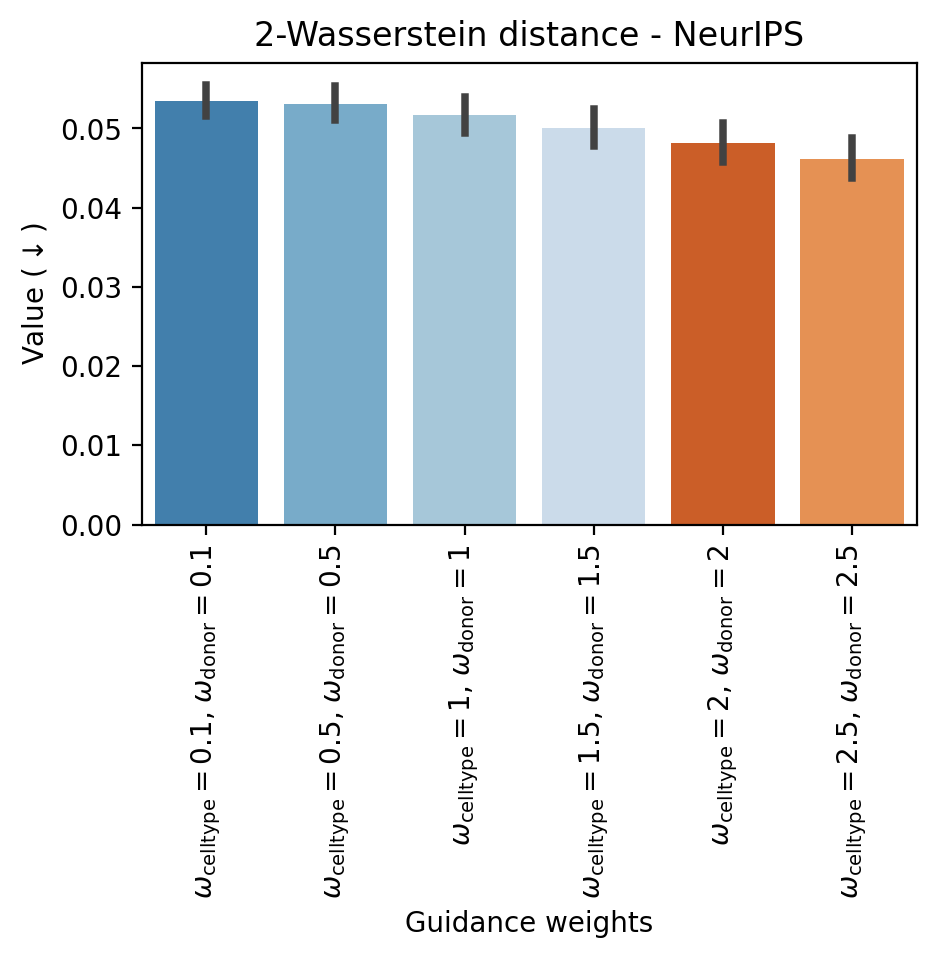

In [53]:
plt.figure(figsize=(5,3))
ax = sns.barplot(data=results_df.loc[results_df["Metric type"]=="2-WD"],
             x="Formatted weights",
             y="Value", order=unique_labs, palette="tab20c")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
plt.ylabel("Value ($\downarrow)$")
plt.title("2-Wasserstein distance - NeurIPS")
plt.xlabel("Guidance weights")
plt.savefig('2_wd_neurips.svg', format='svg', bbox_inches='tight')
plt.show()

In [37]:
results_df["Value"] = results_df["Value"]/10

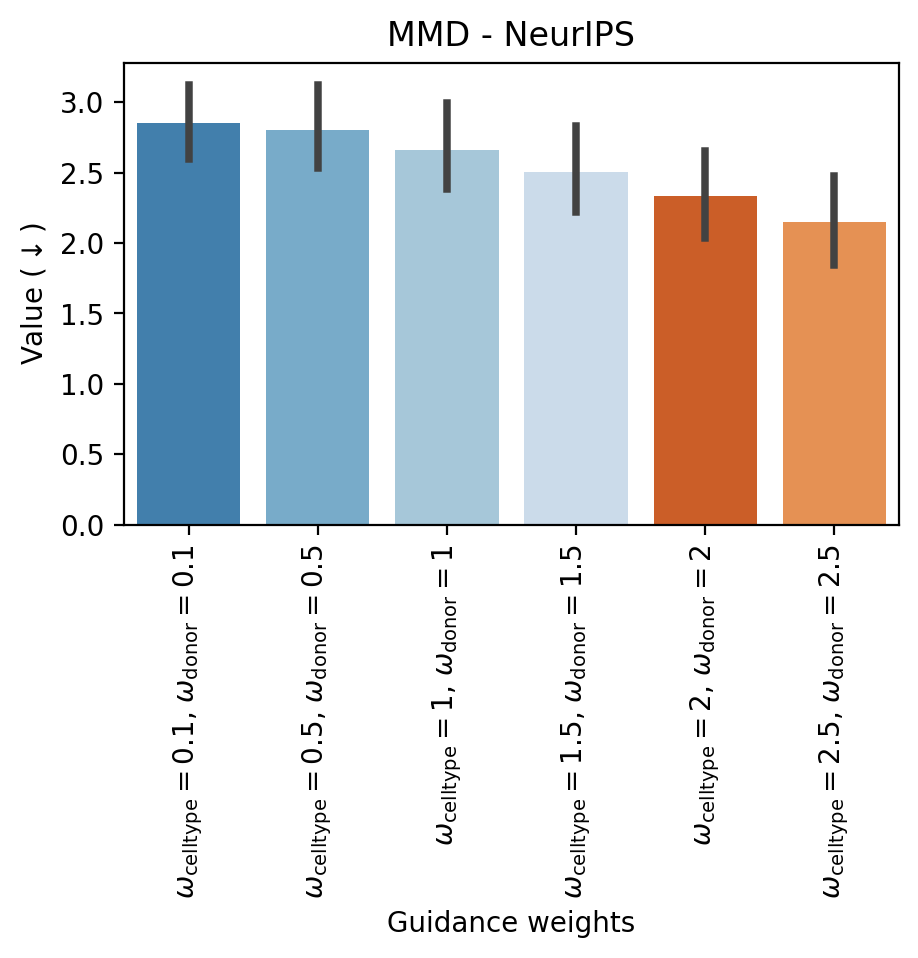

In [54]:
plt.figure(figsize=(5,3))
ax = sns.barplot(data=results_df.loc[results_df["Metric type"]=="Linear MMD"],
             x="Formatted weights",
             y="Value", order=unique_labs, palette="tab20c")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
plt.title("MMD - NeurIPS")
plt.ylabel("Value ($\downarrow)$")
plt.xlabel("Guidance weights")
plt.savefig('2_mmd_neurips.svg', format='svg', bbox_inches='tight')
plt.show()

In [28]:
# plt.figure(figsize=(5,3))
# ax = sns.barplot(data=results_df.loc[results_df["Metric type"]=="RBF MMD"],
#              x="Formatted weights",
#              y="Value", order=unique_labs, palette="tab20c")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
# plt.title("MMD - NeurIPS")
# plt.ylabel("Value ($\downarrow)$")
# plt.xlabel("Guidance weights")
# plt.savefig('2_mmd_neurips.svg', format='svg', bbox_inches='tight')
# plt.show()

In [29]:
# plt.figure(figsize=(5,3))
# ax = sns.barplot(data=results_df.loc[results_df["Metric type"]=="Poly MMD"],
#              x="Formatted weights",
#              y="Value", order=unique_labs, palette="tab20c")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
# plt.title("MMD - NeurIPS")
# plt.ylabel("Value ($\downarrow)$")
# plt.xlabel("Guidance weights")
# plt.savefig('2_mmd_neurips.svg', format='svg', bbox_inches='tight')
# plt.show()

In [30]:
# sns.barplot(data=results_df.loc[results_df["Metric type"]=="2-WD"],
#              x="Formatted weights",
#              y="Value", order=unique_labs, palette="tab20c")
# plt.xticks(rotation=90)

# plt.show()

In [31]:
# sns.barplot(data=results_df.loc[results_df["Metric type"]=="Linear MMD"],
#              x="Formatted weights",
#              y="Value", order=unique_labs, palette="tab20c")
# plt.xticks(rotation=90)

# plt.show()

In [332]:
# sns.barplot(data=results_df.loc[results_df["Metric type"]=="Poly MMD"],
#              x="Formatted weights",
#              y="Value", order=unique_labs, palette="tab20c")
# plt.xticks(rotation=90)

# plt.show()

In [333]:
# sns.barplot(data=results_df.loc[results_df["Metric type"]=="RBF MMD"],
#              x="Formatted weights",
#              y="Value", order=unique_labs, palette="tab20c")
# plt.xticks(rotation=90)

# plt.show()

In [334]:
adata_try = sc.AnnData(X=np.concatenate([guided_adata_generated.X, 
                                            adata_cond.X.A
                                        ]),
                      obs = {"data_type": ["fake" for _ in range(len(guided_adata_generated))] +
                                              ["true"  for _ in range(len(adata_cond))]
                                          })

In [335]:
guided_adata_generated.X.sum(1).mean()

654.09784

In [336]:
adata_cond.X.A.sum(1).mean()

2409.815

In [337]:
sc.tl.pca(adata_try)
sc.pp.neighbors(adata_try)
sc.tl.umap(adata_try)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


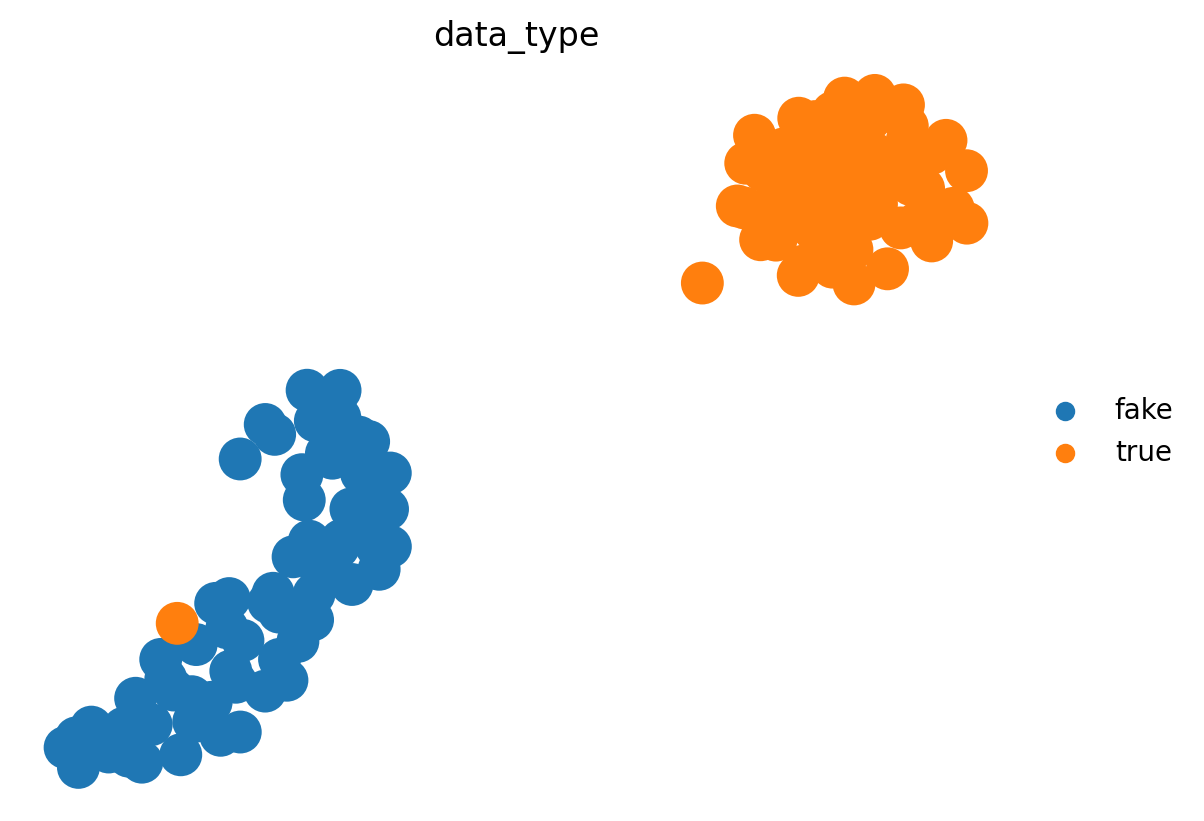

In [338]:
sc.pl.umap(adata_try, color="data_type")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


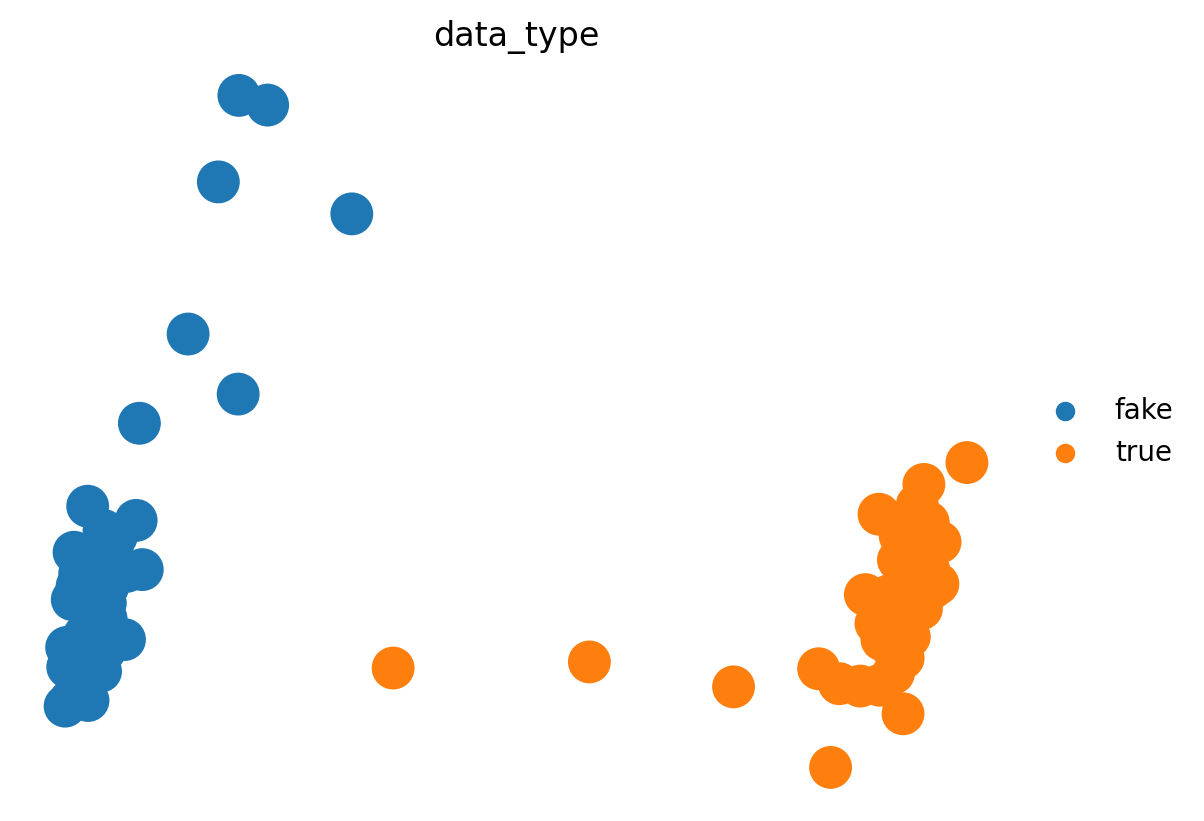

In [339]:
sc.pl.pca(adata_try, color="data_type")